In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import sys 
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
sys.path.append(os.path.abspath("../../"))
import Utilities as utils
import Constants as c
%matplotlib inline

In [2]:
project_name = "linux"
directoryPath = "../../exports"
task = "BUG"
bugs = "{directoryPath}/{project_name}/{project_name}_dataset_{task}.csv".format(directoryPath=directoryPath, project_name=project_name, task=task)

cc_columns = [c.VERSION, c.DATE, c.NT_CC, c.NO_CC, c.MODULE_CC, c.LINE_CC, c.T_MODULE, c.T_LINE, c.T_CC]
df = pd.read_csv(bugs, usecols = cc_columns)
df[c.DATE] = pd.to_datetime(df[c.DATE])
df = df.dropna(subset=[c.T_MODULE])
if df.isna().values.any():
    df.fillna(0, inplace=True)

df = utils.remove_outlier(df, c.LINE_CC)
df = utils.remove_outlier(df, c.MODULE_CC)
# df = df[df.Version.str.contains(r"^[v]{0,1}\d{1,2}\.\d{1,2}\.\d{1,2}[\.\d{1,2}]{0,2}$", regex=True, na=False)]
# df.head()

In [3]:
# df.describe()
# df.dtypes

In [4]:
# display correlation matrix
display(df.corr())

,T_Module,T_Line,NT_CC,NO_CC,Module_CC,Line_CC,T_CC
T_Module,1.000000,0.998789,-0.156619,0.163099,-0.275574,-0.323897,0.496191
T_Line,0.998789,1.000000,-0.170033,0.167316,-0.285295,-0.330820,0.495537
NT_CC,-0.156619,-0.170033,1.000000,0.048215,0.934200,0.791390,0.166747
NO_CC,0.163099,0.167316,0.048215,1.000000,0.090184,0.082002,0.050802
Module_CC,-0.275574,-0.285295,0.934200,0.090184,1.000000,0.868418,0.034345
Line_CC,-0.323897,-0.330820,0.791390,0.082002,0.868418,1.000000,-0.070129
T_CC,0.496191,0.495537,0.166747,0.050802,0.034345,-0.070129,1.000000


In [5]:
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

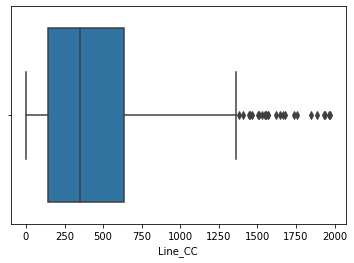

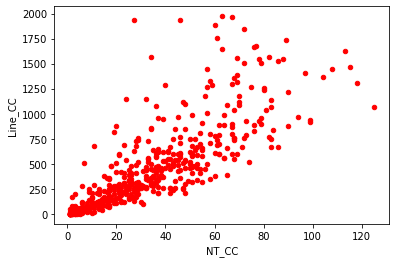

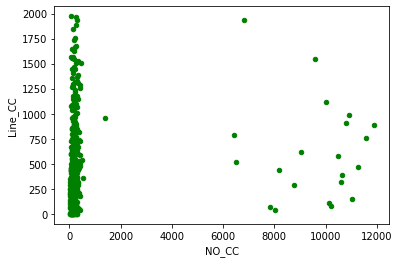

In [6]:
sns.boxplot(x=df[c.LINE_CC])
df.plot.scatter(x=c.NT_CC, y=c.LINE_CC, c='red')
df.plot.scatter(x=c.NO_CC, y=c.LINE_CC, c='green')


In [7]:
# Let's create multiple regression
X = df[[c.NT_CC, c.NO_CC]]
Y = df[c.LINE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)

model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

OLS Regression Results                                
Dep. Variable:                Line_CC   R-squared (uncentered):                   0.838
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              918.5
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                   2.86e-141
Time:                        19:50:01   Log-Likelihood:                         -2497.2
No. Observations:                 358   AIC:                                      4998.
Df Residuals:                     356   BIC:                                      5006.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [8]:
data = {c.OBSERVED:y_test, c.PREDICTED:predictions.round(2), c.DIFFERENCE:abs(y_test - predictions).round(2), c.PERCENT_ERROR:(abs(y_test - predictions)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())
# results

In [9]:
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', model.rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', model.rsquared_adj))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, predictions))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

linux - BUG - Module_CC model performance: 
Model - R Squared: 0.84
Model - R Squared Adj: 0.84
Pred - Mean Absolute Error: 157.06
Pred - Mean Squared Error: 65879.5
Pred - Root Mean Squared Error: 256.67
Pred - PRED (25): 39.17%
Pred - PRED (50): 60.00%


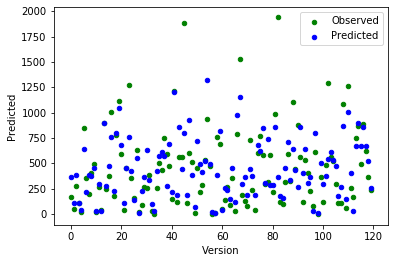

In [10]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

In [11]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [12]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT_CC, fig=regPlotNC)

In [13]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO_CC, fig=regPlotNO)

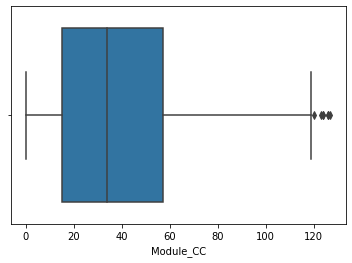

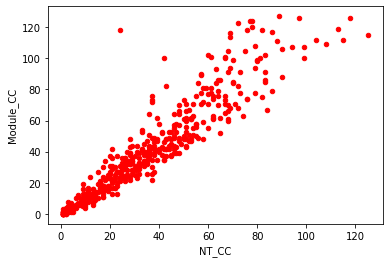

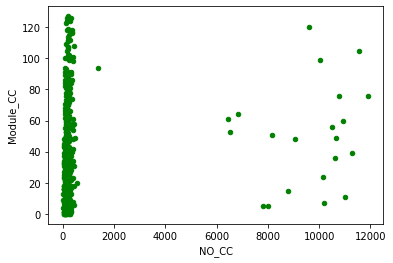

In [14]:
sns.boxplot(x=df[c.MODULE_CC])
df.plot.scatter(x=c.NT_CC, y=c.MODULE_CC, c='red')
df.plot.scatter(x=c.NO_CC,  y=c.MODULE_CC, c='green')


In [15]:
# Let's create multiple regression
X = df[[c.NT_CC, c.NO_CC, c.T_MODULE]]
Y = df[c.MODULE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)

OLS Regression Results                                
Dep. Variable:              Module_CC   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              2291.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                   7.28e-232
Time:                        19:50:07   Log-Likelihood:                         -1380.3
No. Observations:                 358   AIC:                                      2767.
Df Residuals:                     355   BIC:                                      2778.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [16]:
data = {c.OBSERVED:y_test, c.PREDICTED:predictions.round(2), c.DIFFERENCE:abs(y_test - predictions).round(2), c.PERCENT_ERROR:(abs(y_test - predictions)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())
# results

In [17]:
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', model.rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', model.rsquared_adj))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, predictions))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

linux - BUG - Module_CC model performance: 
Model - R Squared: 0.95
Model - R Squared Adj: 0.95
Pred - Mean Absolute Error: 5.85
Pred - Mean Squared Error: 62.47
Pred - Root Mean Squared Error: 7.9
Pred - PRED (25): 67.50%
Pred - PRED (50): 87.50%


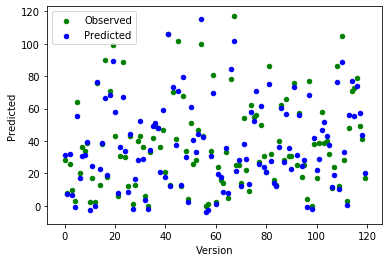

In [18]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

In [19]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [20]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT_CC, fig=regPlotNC)

In [21]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO_CC, fig=regPlotNO)